# ДЗ по "Введение в нейронные сети (Вебинар)"

## Вебинар 4. Сверточные нейронные сети   

* Домашнее задание:  
Поиграться с кодом соревнования по Северстали, получить как можно лучший результат. 
Сдавать как обычно блокно  т

### Введение
Сталь – один из важнейших строительных материалов современности. Стальные здания устойчивы к естественному и искусственному износу, что сделало этот материал повсеместно распространенным во всем мире. Чтобы сделать производство стали более эффективным, этот конкурс поможет выявить дефекты с помощью машинного зрения.


ссылка на каггл с этим соревнованием - https://www.kaggle.com/c/severstal-steel-defect-detection  
статья о соревновании - https://vc.ru/severstal/151039-kaggle

### Постановка задачи :

Этот конкурс представляет собой двойной конкурс: классифицируйте тип дефекта стали, а также сегментируйте части изображения, содержащие дефект.



### Решение

In [1]:
# Устанавливаем пакеты в окружение, если они не установлены
# !pip install scikeras[tensorflow]
# !pip install numpy
# !pip install matplotlib
# !python -m pip install --upgrade pip
# !pip install tensorflow
# !pip install pandas
# !pip install seaborn
# !pip install tqdm
# !pip install pyarrow
# !pip install opencv-python
# !pip install imblearn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout
from keras.callbacks import EarlyStopping
import cv2
from imblearn.over_sampling import RandomOverSampler

In [3]:
data = pd.read_csv("content/train.csv")

In [4]:
data

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [5]:
data.shape

(7095, 3)

У нас 7095 и три фичи

### Разведочный анализ данных

ClassId
3    5150
1     897
4     801
2     247
Name: count, dtype: int64

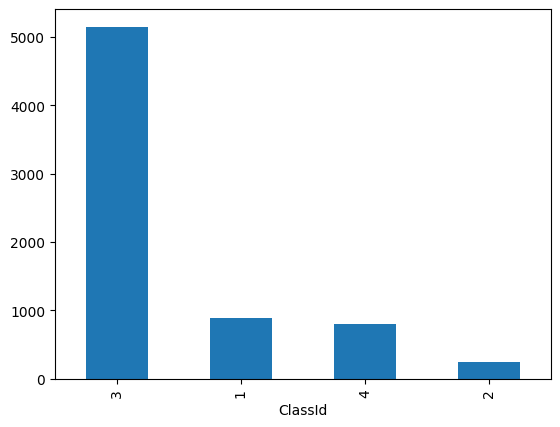

In [6]:
data["ClassId"].value_counts().plot(kind = 'bar')
data["ClassId"].value_counts()

больше всего меток третьего класса

Перекос данных, поэтому выполним аугментацию.

In [7]:
l1=[]
l2=[]
for img,ClassId,EncodedPixels in tqdm(data.values):
    image=cv2.imread("content/train_images/{}".format(img),cv2.IMREAD_COLOR)
    image=cv2.resize(image,(120,120))
    l1.append(image)
    l2.append(ClassId)

100%|██████████| 7095/7095 [00:27<00:00, 256.33it/s]


Проверка изображений случайной стали, чтобы проверить, дефектна ли она или нет.

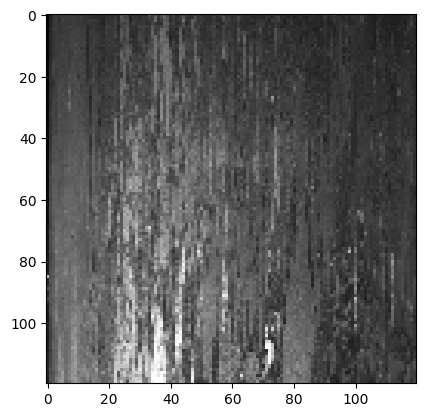

In [8]:
i = 15
plt.imshow(l1[i])

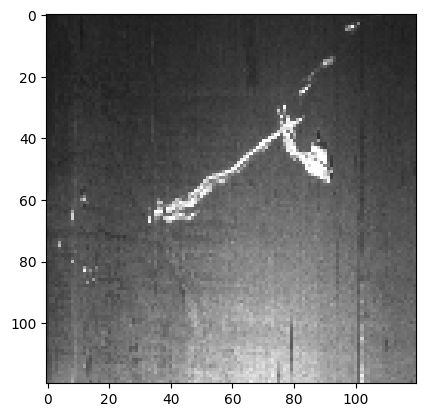

In [9]:
i = 16
plt.imshow(l1[i])

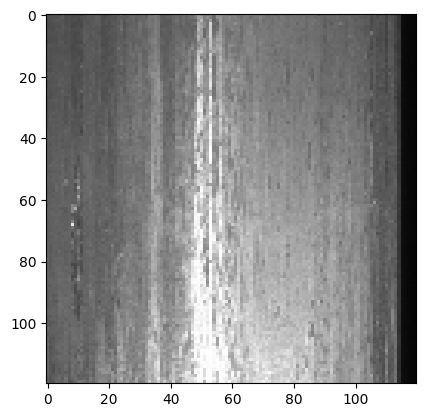

In [10]:
i = 90
plt.imshow(l1[i])

Выполним one-hot кодировку

In [11]:
encoder = LabelEncoder()

X= np.array(l1)
X = X/255

y = encoder.fit_transform(l2)
y = np.array(y)


In [12]:
X.shape

(7095, 120, 120, 3)

In [13]:
y.shape

(7095,)

### Борьба с дибалансом

для борьбы с дисбалансом выполним случайное сэмплирование

In [14]:
reshaped_X = X.reshape(X.shape[0],-1)
oversample = RandomOverSampler(sampling_strategy='not majority')
X, y  = oversample.fit_resample(reshaped_X , y)
X = X.reshape(-1,120,120,3)

In [15]:
X.shape

(20600, 120, 120, 3)

In [16]:

y = to_categorical(y)

In [17]:
y

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

разделим на тренировку и валидацию

In [18]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True)

In [19]:
print("x_train размер:",X_train.shape)
print("x_test размер:",X_test.shape)
print("y_train размер:",y_train.shape)
print("y_test размер:",y_test.shape)

x_train размер: (16480, 120, 120, 3)
x_test размер: (4120, 120, 120, 3)
y_train размер: (16480, 4)
y_test размер: (4120, 4)


### Создаём callback EarlyStopping (защита от переобучения)
см. [ссылка ToTube](https://www.youtube.com/watch?v=aiH_oXtuzjE) 

In [20]:
# Настраиваем защиту от переобучения
erly_stoping_callback = EarlyStopping(monitor='val_accuracy', patience=2)  # Если метрика 'val_accuracy' продолжает снижение два шага подряд,
                                                                           # то выходим из процесса обучения

In [21]:
# Задаем переменные
EPOCH = 25                                 # Количество эпох обучения
BATCH_SIZE = 128                           # Сколько элементов массива обработает модель за один шаг обучения 

### Построение нейронной сети  в 3 слоя и график обучения

In [22]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model.add(Flatten())
model.add(Dense(4,activation="softmax"))

In [23]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [24]:
history = model.fit(X_train,y_train,epochs=EPOCH,validation_data=(X_test,y_test),batch_size=BATCH_SIZE,
                    verbose=1, callbacks=[erly_stoping_callback])

Epoch 1/25
129/129 [==============================] - 22s 166ms/step - loss: 1.8908 - accuracy: 0.5811 - val_loss: 0.7292 - val_accuracy: 0.6573
Epoch 2/25
129/129 [==============================] - 21s 163ms/step - loss: 0.6009 - accuracy: 0.7672 - val_loss: 0.5169 - val_accuracy: 0.8131
Epoch 3/25
129/129 [==============================] - 20s 155ms/step - loss: 0.4195 - accuracy: 0.8577 - val_loss: 0.4324 - val_accuracy: 0.8517
Epoch 4/25
129/129 [==============================] - 20s 156ms/step - loss: 0.3082 - accuracy: 0.9078 - val_loss: 0.3453 - val_accuracy: 0.8947
Epoch 5/25
129/129 [==============================] - 21s 159ms/step - loss: 0.2409 - accuracy: 0.9311 - val_loss: 0.3362 - val_accuracy: 0.8973
Epoch 6/25
129/129 [==============================] - 21s 161ms/step - loss: 0.2116 - accuracy: 0.9417 - val_loss: 0.3253 - val_accuracy: 0.8993
Epoch 7/25
129/129 [==============================] - 20s 156ms/step - loss: 0.1847 - accuracy: 0.9504 - val_loss: 0.2913 - val_ac

In [25]:
if erly_stoping_callback.stopped_epoch >=1:
    print('Обучение остановлено на эпохе', erly_stoping_callback.stopped_epoch)

Обучение остановлено на эпохе 10


<Axes: title={'center': 'Loss curve'}>

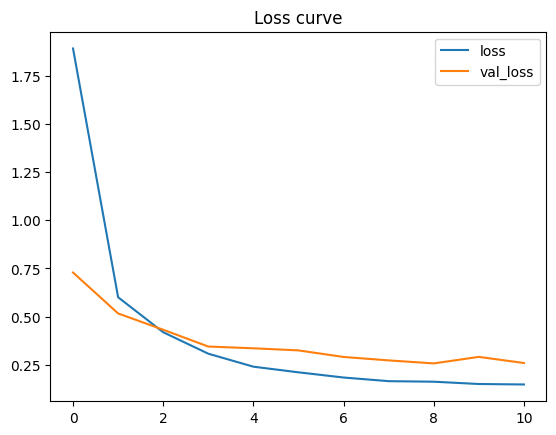

In [26]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

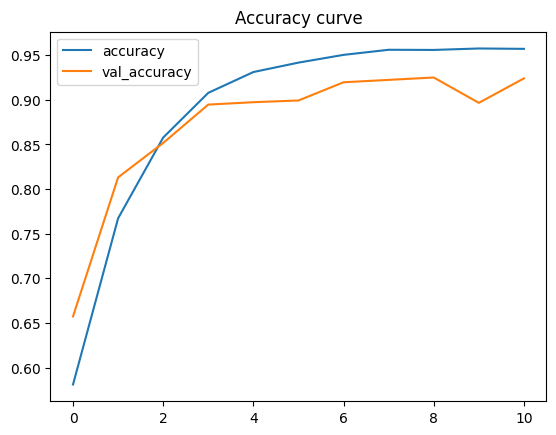

In [27]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

In [28]:
# Оцениваем работу модели из 3-х слоёв, на тестовых данных
result = model.evaluate(X_test, y_test)

loss = result[0]
accuracy = result[1]
print(f"[+] Accuracy: {accuracy*100:.2f}%")

129/129 [==============================] - 3s 19ms/step - loss: 0.2599 - accuracy: 0.9240
[+] Accuracy: 92.40%


### Построение нейронной сети  в 5 слоев

In [29]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))

In [30]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [31]:
history = model.fit(X_train,y_train,epochs=EPOCH,validation_data=(X_test,y_test),batch_size=BATCH_SIZE,
                    verbose=1, callbacks=[erly_stoping_callback])

Epoch 1/25
129/129 [==============================] - 29s 212ms/step - loss: 1.1882 - accuracy: 0.6004 - val_loss: 0.7077 - val_accuracy: 0.7129
Epoch 2/25
129/129 [==============================] - 24s 187ms/step - loss: 0.6104 - accuracy: 0.7672 - val_loss: 0.5352 - val_accuracy: 0.8100
Epoch 3/25
129/129 [==============================] - 25s 197ms/step - loss: 0.4743 - accuracy: 0.8282 - val_loss: 0.4838 - val_accuracy: 0.8231
Epoch 4/25
129/129 [==============================] - 25s 195ms/step - loss: 0.3783 - accuracy: 0.8691 - val_loss: 0.4320 - val_accuracy: 0.8483
Epoch 5/25
129/129 [==============================] - 27s 206ms/step - loss: 0.3153 - accuracy: 0.8924 - val_loss: 0.3724 - val_accuracy: 0.8595
Epoch 6/25
129/129 [==============================] - 26s 203ms/step - loss: 0.2774 - accuracy: 0.9081 - val_loss: 0.3401 - val_accuracy: 0.8867
Epoch 7/25
129/129 [==============================] - 26s 198ms/step - loss: 0.2349 - accuracy: 0.9248 - val_loss: 0.3762 - val_ac

In [32]:
if erly_stoping_callback.stopped_epoch >=1:
    print('Обучение остановлено на эпохе', erly_stoping_callback.stopped_epoch)

Обучение остановлено на эпохе 10


<Axes: title={'center': 'Loss curve'}>

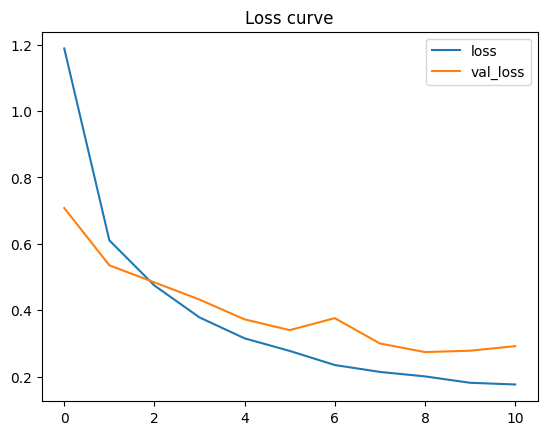

In [33]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

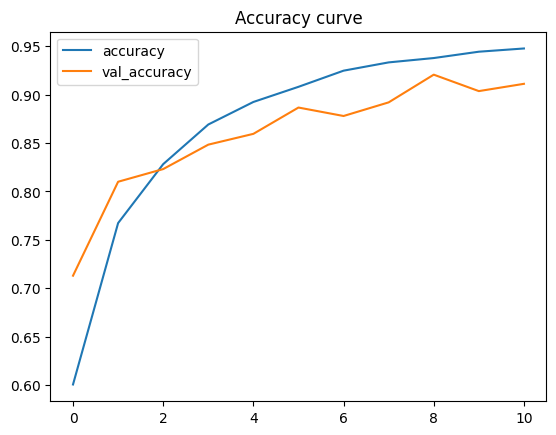

In [34]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

In [35]:
# Оцениваем работу модели из 5-и слоёв, на тестовых данных
result = model.evaluate(X_test, y_test)

loss = result[0]
accuracy = result[1]
print(f"[+] Accuracy: {accuracy*100:.2f}%")

129/129 [==============================] - 2s 17ms/step - loss: 0.2918 - accuracy: 0.9112
[+] Accuracy: 91.12%


### Построение нейронной сети в 13 слоев и обучение

In [36]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))

Сборка и обучение модели

In [37]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [38]:
history = model.fit(X_train,y_train,epochs=EPOCH,validation_data=(X_test,y_test),batch_size=BATCH_SIZE,
                    verbose=1, callbacks=[erly_stoping_callback])

Epoch 1/25
129/129 [==============================] - 32s 247ms/step - loss: 0.9910 - accuracy: 0.5441 - val_loss: 0.8169 - val_accuracy: 0.6583
Epoch 2/25
129/129 [==============================] - 32s 247ms/step - loss: 0.8122 - accuracy: 0.6630 - val_loss: 0.7137 - val_accuracy: 0.7117
Epoch 3/25
129/129 [==============================] - 31s 240ms/step - loss: 0.7259 - accuracy: 0.6990 - val_loss: 0.6443 - val_accuracy: 0.7461
Epoch 4/25
129/129 [==============================] - 30s 236ms/step - loss: 0.6511 - accuracy: 0.7430 - val_loss: 0.5752 - val_accuracy: 0.7765
Epoch 5/25
129/129 [==============================] - 30s 236ms/step - loss: 0.5793 - accuracy: 0.7734 - val_loss: 0.5413 - val_accuracy: 0.7847
Epoch 6/25
129/129 [==============================] - 31s 237ms/step - loss: 0.5304 - accuracy: 0.7965 - val_loss: 0.5016 - val_accuracy: 0.8041
Epoch 7/25
129/129 [==============================] - 31s 237ms/step - loss: 0.4914 - accuracy: 0.8117 - val_loss: 0.4717 - val_ac

In [39]:
if erly_stoping_callback.stopped_epoch >=1:
    print('Обучение остановлено на эпохе', erly_stoping_callback.stopped_epoch)

Обучение остановлено на эпохе 20


### Анализ результатов обучения

<Axes: title={'center': 'Loss curve'}>

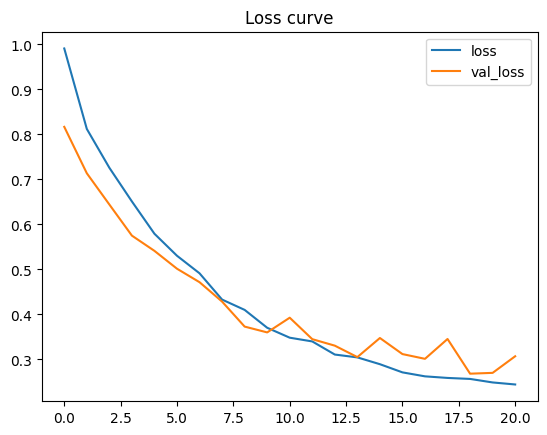

In [40]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

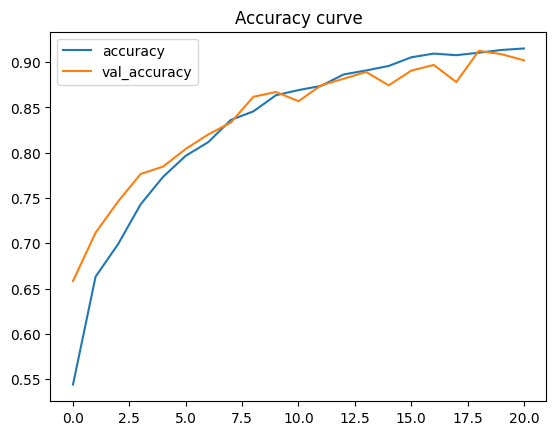

In [41]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

In [42]:
# Оцениваем работу модели из 15-и слоёв, на тестовых данных
result = model.evaluate(X_test, y_test)

loss = result[0]
accuracy = result[1]
print(f"[+] Accuracy: {accuracy*100:.2f}%")

129/129 [==============================] - 2s 18ms/step - loss: 0.3071 - accuracy: 0.9019
[+] Accuracy: 90.19%


In [43]:
from keras.models import Model
model.save('webinar_4_model.keras')

In [44]:
from keras.models import load_model

loaded_model = load_model('webinar_4_model.keras')


### Архитектура созданной нейронной сети

In [45]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 2, 64)        

### Тестирование на новых примерах

In [46]:
l2[:3]

[1, 3, 1]

In [47]:
X= np.array(l1[:3])
X = X/255

y = encoder.fit_transform(l2[:3])
y = np.array(y)

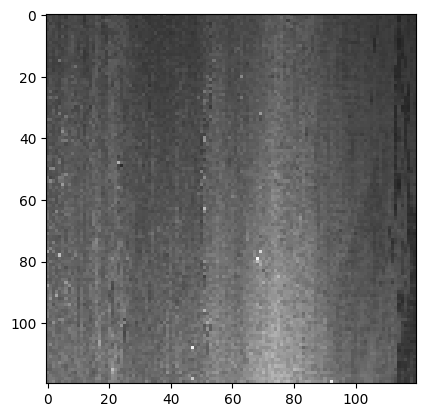

In [48]:
plt.imshow(l1[0]);

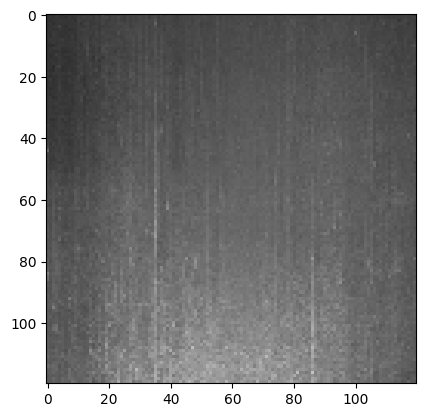

In [49]:
plt.imshow(l1[1]);

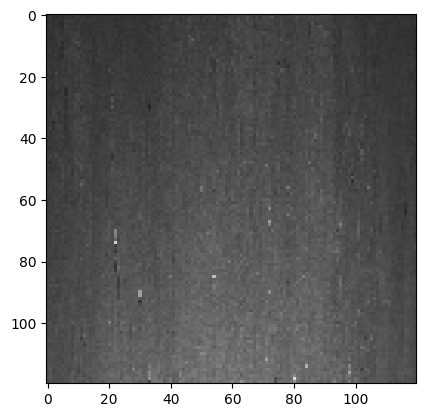

In [50]:
plt.imshow(l1[2]);

In [51]:
y =  to_categorical(y)
y

array([[1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [52]:

predictions = model.predict(X)
predictions

1/1 [==============================] - 0s 134ms/step


array([[9.4893843e-01, 1.5455732e-04, 5.0906707e-02, 2.5970152e-07],
       [7.6259613e-01, 1.4450015e-04, 2.3724525e-01, 1.4054091e-05],
       [9.7608465e-01, 1.5335185e-03, 2.2381788e-02, 3.9933337e-08]],
      dtype=float32)

Здесь три эксперимента, где мы видим, что тест № 2 был с меткой 3, но неверно идентифицировался как метка 1.

In [53]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 2, 64)        

### описание архитектуры нейронной сети

У нас тут многослойная нейронная сеть с разными типами слоев.

теперь по поводу слоев нейронной сети и их особенностей.

1 слой - Conv2D. Он используется для выполнения двумерной свертки входных данных. Он применяет набор фильтров к входному изображению или карте объектов, перемещая их по входным данным и вычисляя скалярное произведение в каждом месте. Эта операция позволяет слою извлекать объекты и фиксировать пространственные отношения во входных данных. Уровень Conv2D обычно используется в сверточных нейронных сетях (CNN) для таких задач, как классификация изображений, обнаружение объектов и сегментация изображений.

2 слой - MaxPooling2D.  Это  операция понижающей дискретизации, которая уменьшает пространственные размеры (ширину и высоту) входного изображения или карты объектов. Он делит входные данные на непересекающиеся прямоугольники и выводит максимальное значение внутри каждого прямоугольника. Это помогает извлечь наиболее важные функции и снизить вычислительные требования для последующих слоев.

Далее эти слои повторяются еще 2 раза.

7 слой - Flatten. он преобразует входной тензор в одномерный массив, эффективно выравнивая его. Он принимает многомерный входной тензор, например двумерное изображение, и преобразует его в одномерный вектор, который можно использовать в качестве входных данных для полностью связного слоя или любого другого слоя, который ожидает одномерных входных данных.

8 слой - Dense. это полностью связный слой, который соединяет каждый нейрон предыдущего слоя с каждым нейроном текущего слоя. Он выполняет линейную операцию над входными данными, за которой следует функция активации, позволяющая сети изучать сложные закономерности и взаимосвязи в данных. Количество нейронов в плотном слое определяет размерность вывода.

9 cлой - Dropout. это метод регуляризации, используемый для уменьшения переобучения в нейронных сетях. Он случайным образом устанавливает для части входных единиц значение 0 на каждом этапе обучения, что помогает предотвратить слишком большую зависимость сети от конкретных функций или корреляций. Dropout улучшает способность модели к обобщению за счет внесения шума во время обучения и побуждает сеть изучать более надежные и независимые представления.

Далее слои повторяются.

В итоге в данной нейронной сети 12 различных слоев, и 139 780 параметров.

## Вывод:  
## Лучший результат показала трехслойная НС (Accuracy: 92.40%), был также опробован метод защиты от переобучения (EarlyStopping), метод настройки скорости обучения (см. ДЗ webinar_3.ipynb) плохо показал себя, если просто задать оптимизатор Adam без настройки скорости обучения, то результаты гораздо лучше.